<a href="https://colab.research.google.com/github/HarshG01001/AIHC-Assignment-2-Case-Studies/blob/main/CaseStudy3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings

warnings.filterwarnings('ignore')

In [4]:
# The file is loaded directly by its name as it's already in the Colab environment
file_name = 'train_genetic_disorders.csv'
df = pd.read_csv(file_name)

print(f"'{file_name}' loaded successfully.")

# Separate features from the true labels
target_labels_disorder = df['Genetic Disorder']
X = df.drop(columns=['Patient Id', 'Patient First Name', 'Family Name', 'Institute Name', 'Location of Institute', 'Genetic Disorder', 'Disorder Subclass'])

'train_genetic_disorders.csv' loaded successfully.


In [5]:
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Handle missing values using simple imputation
print("Handling missing values...")
for col in numerical_features:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)

for col in categorical_features:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)

print("Missing values handled.")

Handling missing values...
Missing values handled.


In [6]:
# Create a preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Apply the preprocessing
X_processed = preprocessor.fit_transform(X)
print(f"Data processed. Shape of processed data: {X_processed.shape}")

Data processed. Shape of processed data: (22083, 15844)


In [7]:
# Determine the number of clusters from the data's target variable
n_clusters = len(target_labels_disorder.unique())
print(f"Applying K-Means with {n_clusters} clusters...")

# Apply K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_processed)

# Evaluate K-Means
kmeans_silhouette = silhouette_score(X_processed, kmeans_labels)
kmeans_db_index = davies_bouldin_score(X_processed.toarray(), kmeans_labels)

print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f} (Higher is better)")
print(f"K-Means Davies-Bouldin Index: {kmeans_db_index:.4f} (Lower is better)")

Applying K-Means with 4 clusters...
K-Means Silhouette Score: -0.0303 (Higher is better)
K-Means Davies-Bouldin Index: 3.6588 (Lower is better)


In [8]:
print(f"\nApplying Hierarchical Clustering with {n_clusters} clusters...")

# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_labels = hierarchical.fit_predict(X_processed.toarray())

# Evaluate Hierarchical Clustering
hierarchical_silhouette = silhouette_score(X_processed, hierarchical_labels)
hierarchical_db_index = davies_bouldin_score(X_processed.toarray(), hierarchical_labels)

print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.4f} (Higher is better)")
print(f"Hierarchical Clustering Davies-Bouldin Index: {hierarchical_db_index:.4f} (Lower is better)")


Applying Hierarchical Clustering with 4 clusters...
Hierarchical Clustering Silhouette Score: -0.0440 (Higher is better)
Hierarchical Clustering Davies-Bouldin Index: 4.3475 (Lower is better)


In [9]:
print("\nApplying DBSCAN...")

# DBSCAN is sensitive to parameters and may require tuning
dbscan = DBSCAN(eps=2.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_processed)

num_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN found {num_dbscan_clusters} clusters and identified {(dbscan_labels == -1).sum()} noise points.")


Applying DBSCAN...
DBSCAN found 1 clusters and identified 21011 noise points.


In [10]:
print("\nReducing dimensionality with PCA for visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed.toarray())

# Create a DataFrame for easy plotting
df_pca = pd.DataFrame(data=X_pca, columns=['PCA Component 1', 'PCA Component 2'])
df_pca['KMeans_Cluster'] = kmeans_labels
df_pca['Hierarchical_Cluster'] = hierarchical_labels
df_pca['DBSCAN_Cluster'] = dbscan_labels
df_pca['Actual_Disorder'] = target_labels_disorder

print("PCA complete. Ready for plotting.")


Reducing dimensionality with PCA for visualization...
PCA complete. Ready for plotting.


Generating visualization plots...


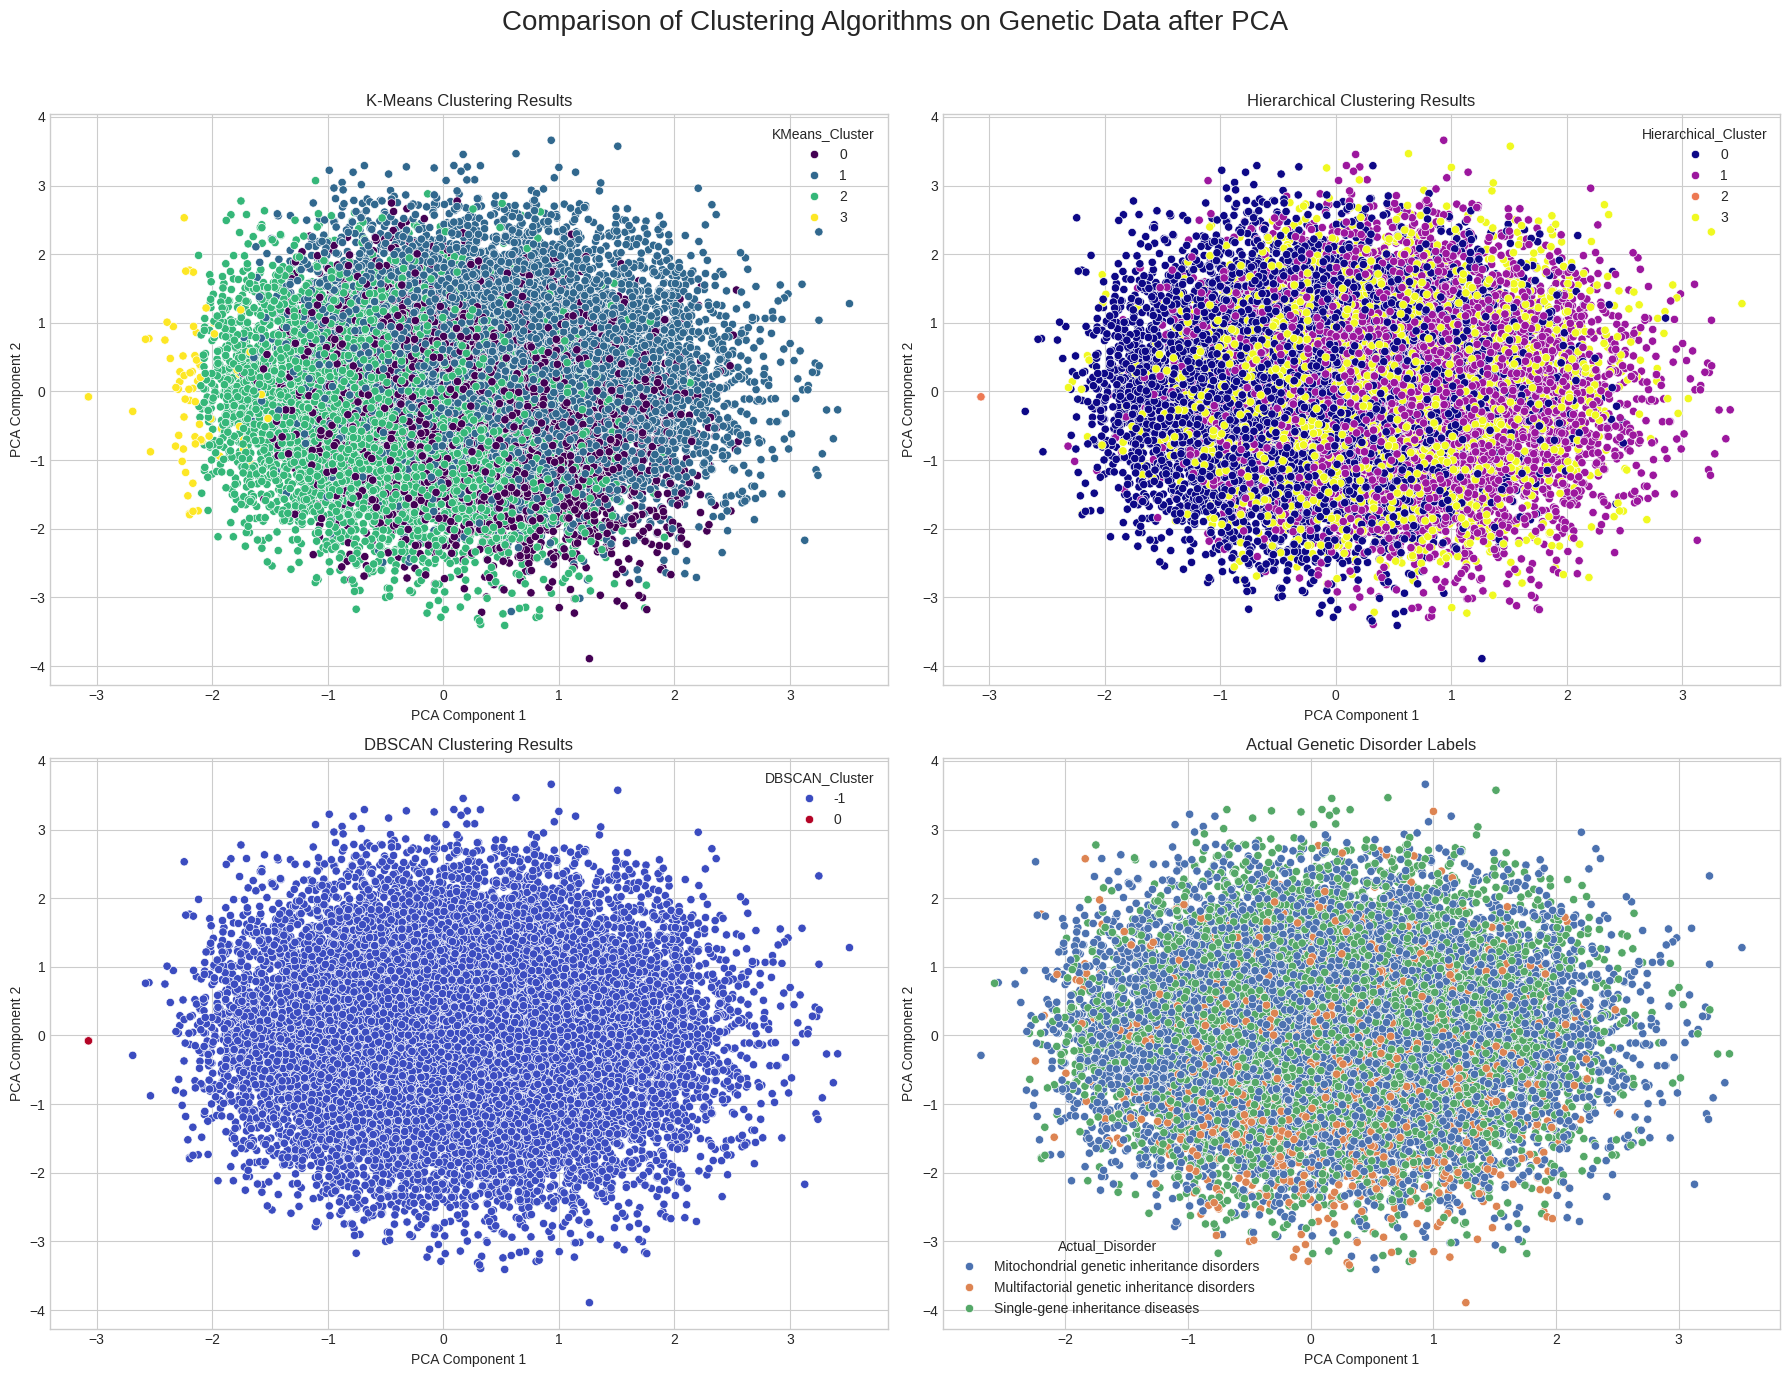

In [11]:
print("Generating visualization plots...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Comparison of Clustering Algorithms on Genetic Data after PCA', fontsize=20)

# K-Means Plot
sns.scatterplot(data=df_pca, x='PCA Component 1', y='PCA Component 2', hue='KMeans_Cluster', palette='viridis', ax=axes[0, 0], legend='full')
axes[0, 0].set_title('K-Means Clustering Results')

# Hierarchical Plot
sns.scatterplot(data=df_pca, x='PCA Component 1', y='PCA Component 2', hue='Hierarchical_Cluster', palette='plasma', ax=axes[0, 1], legend='full')
axes[0, 1].set_title('Hierarchical Clustering Results')

# DBSCAN Plot
sns.scatterplot(data=df_pca, x='PCA Component 1', y='PCA Component 2', hue='DBSCAN_Cluster', palette='coolwarm', ax=axes[1, 0], legend='full')
axes[1, 0].set_title('DBSCAN Clustering Results')

# Actual Genetic Disorder Plot (Ground Truth)
sns.scatterplot(data=df_pca, x='PCA Component 1', y='PCA Component 2', hue='Actual_Disorder', palette='deep', ax=axes[1, 1], legend='full')
axes[1, 1].set_title('Actual Genetic Disorder Labels')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()